loading training data
loading test data


step 0, training accuracy 0.530955
step 0, cost 250.253
step 0, change in cost 250.253
step 1000, training accuracy 0.822665
step 1000, cost 203.078
step 1000, change in cost 47.175
step 2000, training accuracy 0.912907
step 2000, cost 173.492
step 2000, change in cost 29.5861
step 3000, training accuracy 0.937041
step 3000, cost 151.812
step 3000, change in cost 21.6797
step 4000, training accuracy 0.95383
step 4000, cost 135.302
step 4000, change in cost 16.5102
step 5000, training accuracy 0.955929
step 5000, cost 122.354
step 5000, change in cost 12.9479
step 6000, training accuracy 0.962225
step 6000, cost 111.965
step 6000, change in cost 10.3889
step 7000, training accuracy 0.964323
step 7000, cost 103.446
step 7000, change in cost 8.51946
step 8000, training accuracy 0.966422
step 8000, cost 96.3255
step 8000, change in cost 7.12006
step 9000, training accuracy 0.96852
step 9000, cost 90.2808
step 9000, change in cost 6.04466
step 10000, training accuracy 0.96957
step 10000, co

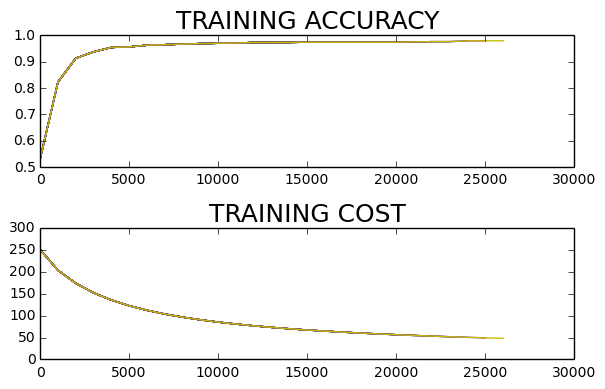

In [1]:
################
### PREAMBLE ###
################

from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time

%matplotlib inline

###################
### IMPORT DATA ###
###################

def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()



#########################
### GLOBAL PARAMETERS ###
#########################

## DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]

## TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.005,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)





####################
### PLACEHOLDERS ###
####################

# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])



#################
### VARIABLES ###
#################

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))



######################
### PREDICTION OPS ###
######################

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")


#####################
### EVALUATION OP ###
#####################

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")


#######################
### OPTIMIZATION OP ###
#######################

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)


###########################
### GRAPH LIVE UPDATING ###
###########################

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()



#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph_def)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 1000 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))


##############################
### SAVE TRAINED VARIABLES ###
##############################

# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
# saver.save(sess, "trained_variables.ckpt")


############################
### MAKE NEW PREDICTIONS ###
############################

# Close tensorflow session
sess.close()

# To view tensorboard:
    #1. run: tensorboard --logdir=/path/to/log-directory
    #2. open your browser to http://localhost:6006/
# See tutorial here for graph visualization:
# https://www.tensorflow.org/versions/0.6.0/how_tos/graph_viz/index.html
